In [1]:
from google.colab import drive
import os

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()


Mounted at /content/drive
Current directory: /content/drive/MyDrive/rsna_data


In [ ]:
!tree -L 1 # !apt install tree 후 실행
"""
├── sample_submission.csv - submission 제출 예시 파일
├── segmentations - nii 세분화 폴더
├── test_dicom_tags.parquet - tag parquet파일
├── test_images - test 이미지
├── test_series_meta.csv - test 시리즈 메타 csv
├── train (1).csv - 아래의 것과 동일
├── train.csv - 트레인 이미지 메타 csv
├── train_image - dummy
├── train_images - train 이미지
└── train_series_meta.csv - train 시리즈 메타 csv
"""

/bin/bash: line 1: tree: command not found


'\n├── sample_submission.csv - submission 제출 예시 파일\n├── segmentations - nii 세분화 폴더\n├── test_dicom_tags.parquet - tag parquet파일\n├── test_images - test 이미지\n├── test_series_meta.csv - test 시리즈 메타 csv\n├── train (1).csv - 아래의 것과 동일\n├── train.csv - 트레인 이미지 메타 csv\n├── train_image - dummy\n├── train_images - train 이미지\n└── train_series_meta.csv - train 시리즈 메타 csv\n'

In [ ]:
import pandas as pd

def df_info(df):
    """
    Display information about a DataFrame.

    Args:
    - df (pd.DataFrame): Input DataFrame
    """
    # Shape
    print("Shape:", df.shape)

    # Info
    print("\nInfo:")
    print(df.info())

    # Unique value counts for each column
    print("\nDistinct count and unique values for each column:")
    for col in df.columns:
        print(f"{col} (Distinct Count: {df[col].nunique()}): {df[col].unique()}")

    # Null value counts for each column
    print("\nNull values for each column:")
    for col in df.columns:
        print(f"{col}: {df[col].isnull().sum()}")

    # Descriptive statistics for each column
    print("\nDescriptive Statistics:")
    print(df.describe(include='all'))

    # Value counts for each column
    for col in df.columns:
        print(f"\nValue counts for column {col}:")
        print(df[col].value_counts())

#test_series_meta.csv
#sample_submission.csv
#train.csv
#train_series_meta.csv
# train (1).csv
test = pd.read_csv('train.csv')

df_info(test)

Shape: (3147, 15)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patient_id             3147 non-null   int64
 1   bowel_healthy          3147 non-null   int64
 2   bowel_injury           3147 non-null   int64
 3   extravasation_healthy  3147 non-null   int64
 4   extravasation_injury   3147 non-null   int64
 5   kidney_healthy         3147 non-null   int64
 6   kidney_low             3147 non-null   int64
 7   kidney_high            3147 non-null   int64
 8   liver_healthy          3147 non-null   int64
 9   liver_low              3147 non-null   int64
 10  liver_high             3147 non-null   int64
 11  spleen_healthy         3147 non-null   int64
 12  spleen_low             3147 non-null   int64
 13  spleen_high            3147 non-null   int64
 14  any_injury             3147 non-null   int64
dtypes: int64(15)


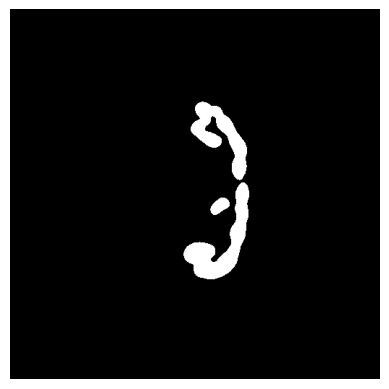

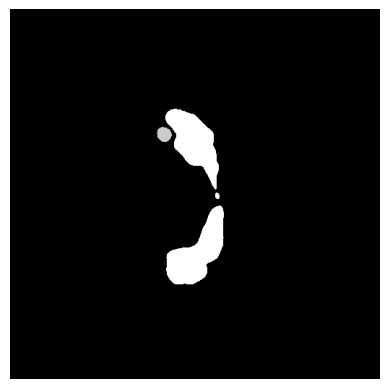

In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

# segmentations 용으로 만들어놨는데, 고용량 ram으로 돌리면 딱 맞음 32GB정도 사용하는듯
def load_all_nii_files():
    """
    Load all NIfTI files from the specified directory.

    Returns:
    - list: List of loaded NIfTI image objects.
    """
    nii_files = [f for f in os.listdir("segmentations") if f.endswith('.nii') or f.endswith('.nii.gz')]
    nii_images = [nib.load(os.path.join("segmentations", f)) for f in nii_files]

    return nii_images

def plot_nii_images(nii_images, num_to_plot=2):
    """
    Plot slices from the provided NIfTI image objects.

    Args:
    - nii_images (list): List of NIfTI image objects.
    - num_to_plot (int): Number of images to plot.
    """
    for nii in nii_images[:num_to_plot]:
        data = nii.get_fdata()
        slice_idx = data.shape[2] // 2
        plt.imshow(data[:, :, slice_idx], cmap='gray')
        plt.axis('off')
        plt.show()

all_nii_images = load_all_nii_files()
plot_nii_images(all_nii_images, num_to_plot=2)


In [ ]:
!pip install pydicom matplotlib numpy

import os
import pydicom
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from concurrent.futures import ProcessPoolExecutor

In [ ]:
class DICOMAnimation:

    def __init__(self, folder_path: str):
        """
        Initialize the DICOMAnimation class.

        Args:
            folder_path (str): Path to the directory containing the DICOM files.

        Attributes:
            folder_path (str): Path to the directory.
            images (list): List containing pixel arrays of the DICOM images.
        """
        self.folder_path = folder_path
        self.images = self._load_images()

    def _load_single_image(self, filename: str) -> np.ndarray:
        """
        Load a single DICOM file and return its pixel array.

        Args:
            filename (str): Name of the DICOM file to load.

        Returns:
            np.ndarray: Pixel array of the loaded DICOM image.
        """
        return pydicom.read_file(os.path.join(self.folder_path, filename)).pixel_array

    def _load_images(self) -> list:
        """
        Load all DICOM files from the specified directory in parallel.

        Returns:
            list: List containing pixel arrays of all the DICOM images in the directory.
        """
        dicom_files = [filename for filename in os.listdir(self.folder_path) if filename.endswith('.dcm')]
        dicom_files.sort()

        # Use multiprocessing to load DICOM files in parallel
        with ProcessPoolExecutor() as executor:
            images_data = list(executor.map(self._load_single_image, dicom_files))
        return images_data

    def show(self) -> HTML:
        """
        Display the DICOM images as an animation.

        Returns:
            HTML: An HTML object to display the animation in Jupyter Notebooks.
        """
        fig, ax = plt.subplots()
        im = ax.imshow(self.images[0], cmap=plt.cm.bone)
        ax.axis('off')

        def update(i: int) -> list:
            """
            Update each frame of the animation.

            Args:
                i (int): Index of the current frame.

            Returns:
                list: List containing the updated image object.
            """
            im.set_array(self.images[i])
            return [im]

        ani = animation.FuncAnimation(fig, update, frames=range(len(self.images)), repeat=True, blit=True)
        return HTML(ani.to_jshtml())

dicom_viewer = DICOMAnimation('train_images/10004/21057')
dicom_viewer.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib

import os
from glob import glob
from tqdm import tqdm, trange

import plotly.express as px
from pprint import pprint
import nibabel as nib
from ipywidgets import interact

In [ ]:
train_meta = pd.read_csv('train_series_meta.csv')
train_info = pd.read_csv('train.csv')

In [ ]:
# df_info(train_meta) # 4711 명의 환자, 시리얼 번호 등... Null 없고, 매핑 파일일듯
df_info(train_info) # 이게 실제 환자 인포

In [ ]:
fig = px.pie(train_info, names=train_info['any_injury'].map({1: 'Patient Injured', 0: 'No Injury'}), height=500, width= 500, color_discrete_sequence=['#D3D3D3','#71797E'], title='Injuries reported in patients')
fig.update_traces(textfont_size=15)
fig.show()

In [ ]:
for column in train_info.columns[2:4]:
    fig = px.pie(train_info, names=train_info[column].map({1: 'Healthy', 0: 'Injury'}), height=450, width= 450, color_discrete_sequence=['#E5E4E2','#71797E', '#D3D3D3'],
             title=f' Pie-Chart of {column}')
    fig.update_traces(textfont_size=15)
    fig.show()

In [ ]:
for column in train_info.columns[4:]:
    fig = px.pie(train_info, names=train_info[column].map({2: 'Healthy', 1: 'High Level Injury', 0: 'Low Level Injury'}), height=500, width= 500, color_discrete_sequence=['#E5E4E2','#71797E', '#D3D3D3'],
             title=f' Pie-Chart of {column}')
    fig.update_traces(textfont_size=15)
    fig.show()

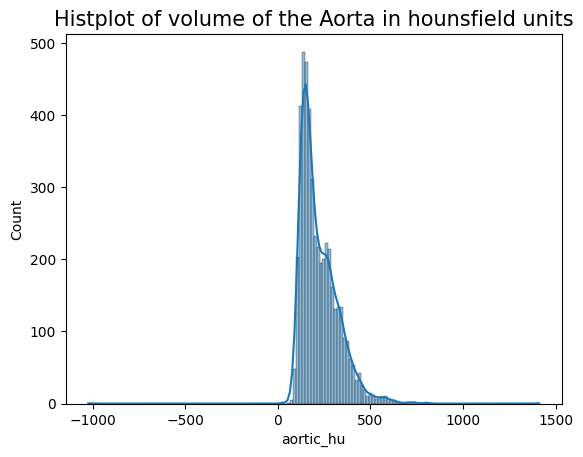

In [ ]:
sns.histplot(train_meta['aortic_hu'],kde=True)
plt.title('Histplot of volume of the Aorta in hounsfield units',fontsize=15)
plt.show()

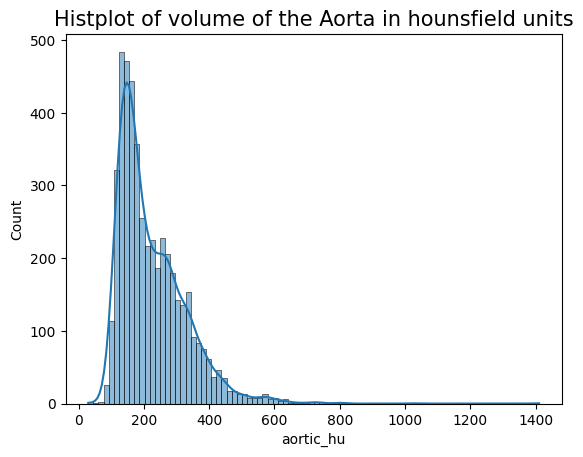

In [ ]:
sns.histplot(np.abs(train_meta['aortic_hu']), kde=True)
plt.title('Histplot of volume of the Aorta in hounsfield units',fontsize=15)
plt.show()

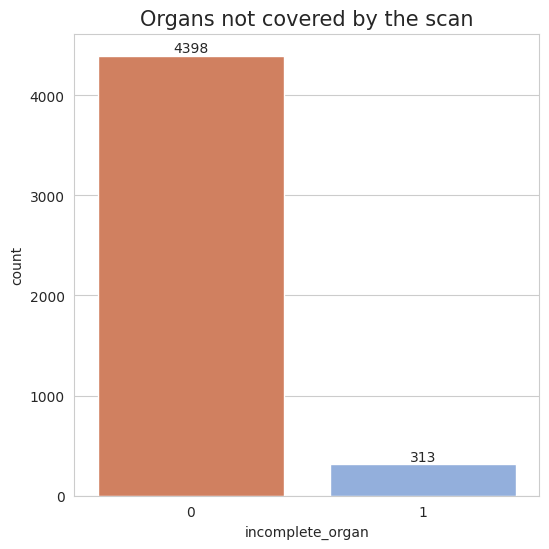

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,6))
ax = sns.countplot(x='incomplete_organ',data=train_meta, palette=['#e3784d','#87ace8'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('Organs not covered by the scan',fontsize=15)
plt.show()

fig = px.pie(train_meta, names=train_meta['incomplete_organ'].map({1: 'Organs covered by scan', 0: 'No organs covered by scan'}), height=550, width= 550,
             color_discrete_sequence=['#D3D3D3','#71797E'], title='Organs covered during scan')
fig.update_traces(textfont_size=15)
fig.show()

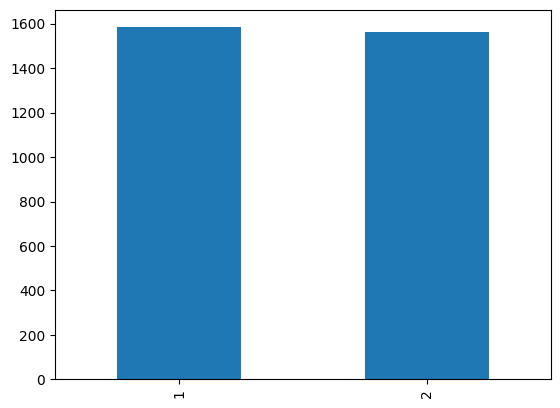

In [ ]:
temp = train_meta['patient_id'].value_counts()
temp.value_counts().plot.bar()
plt.show()

In [ ]:
a = pd.read_parquet("test_dicom_tags.parquet")

In [ ]:
a

,BitsAllocated,BitsStored,Columns,ContentDate,ContentTime,FrameOfReferenceUID,HighBit,ImageOrientationPatient,ImagePositionPatient,InstanceNumber,...,StudyInstanceUID,WindowCenter,WindowWidth,FileMetaInformationVersion,ImplementationClassUID,ImplementationVersionName,MediaStorageSOPClassUID,MediaStorageSOPInstanceUID,TransferSyntaxUID,path
0,16,12,512,20230722,002246.191887,1.2.826.0.1.3680043.8.498.92271913265819460212...,11,"[1, 0, 0, 0, 1, 0]","[-225.609375, -299.609375, -1099]",30,...,1.2.123.12345.1.2.3.48843,50.0,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.48843.1.30,1.2.840.10008.1.2.5,test_images/48843/62825/30.dcm
1,16,16,512,20230722,003830.929278,1.2.826.0.1.3680043.8.498.70045142309401550406...,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[-214.26, -203.431, -172.802]",30,...,1.2.123.12345.1.2.3.50046,50.0,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.50046.1.30,1.2.840.10008.1.2.5,test_images/50046/24574/30.dcm
2,16,12,512,20230722,005441.112500,1.2.826.0.1.3680043.8.498.64877973120200061370...,11,"[1, 0, 0, 0, 1, 0]","[-179.1416015625, -343.1416015625, -477]",30,...,1.2.123.12345.1.2.3.63706,50.0,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.63706.1.30,1.2.840.10008.1.2.5,test_images/63706/39279/30.dcm
